## Reinforcement Learning, Sutton and Barro

This notebook collects solutions for the exercises in the textbook

### Exercise 2.2

How does the softmax action selection using the Gibbs distribution fare on the 10-armed testbed?

In [100]:
import random
import pandas as pd
%matplotlib inline

In [101]:
class RandomVariable:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
    def get(self):
        return abs(random.gauss(self.mu,self.sigma))

In [141]:
class Estimate:
    """Estimate implements last seen estimate
    """
    def __init__(self):
        self.estimate = 0
        self.k = 0
        
    def __gt__(self, e):
        return self.estimate > e.estimate
        
    def update(self, value):
        self.estimate = value
        return self
        
    def get(self):
        return self.estimate

class OnlineAverage(Estimate):
    """OnlineAverage implements incremental mean 
    Q_(k+1) = Q_k + 1/(k+1)(r_(k+1) - Q_k)
    """      
    def update(self, value):
        Q_k = self.estimate
        Q_k = Q_k + 1/(self.k+1) * (value - Q_k)
        self.k = self.k + 1
        self.estimate=Q_k
        return self
    
class Softmax(Estimate):
    """Softmax uses Gibbs softmax
    """
    def update(self, value):
        self.estimate = value
        return self.estimate


In [ ]:
def simulate(RV, I, num_trials, epsilon):
    rewards = []
    for i in range(0, num_trials):
        if random.random() < epsilon:
            max_index = random.randint(0,len(RV) - 1)
        else:
            max_index = I.index(max(I))
        new_reward = RV[max_index].get()
        rewards.append((i,RV[max_index].mu,new_reward))
        I[max_index].update(new_reward)
    return rewards

In [174]:
# implementation of e-greedy N armed bandit

# 1. create N armed bandits and initialize with distributions
max_reward = 9
bandits = [(0,0.1),(1,0.1),(2,0.1),(3,0.1),(4,0.1),(5,0.1),(6,0.1),(7,0.1),(8,0.1),(9,0.1)]
RV = [RandomVariable(x[0],x[1]) for x in bandits]

# 2. setup experiment
num_trials = 10000

# 3. set initial estimates
initial_value = 100
I = [OnlineAverage().update(initial_value) for i in range(0,len(bandits))]

# 4. greedy method will explore alternative path with P = e
epsilon = 0.0

In [175]:
rewards = simulate(RV, I, num_trials, epsilon)

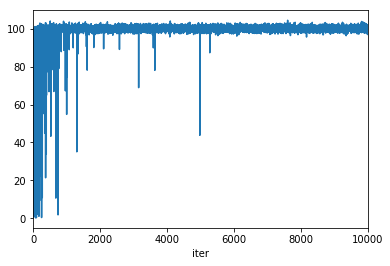

In [178]:
df = pd.DataFrame(rewards, columns=['iter','bandit_mean', 'reward'])
df = df.set_index('iter')
df['percent_optimal'] = (df['reward'] / max_reward) * 100.0
df['percent_optimal'].plot()

## Testing

In [117]:
# testing Estimate
t_1 = [1,2,3,4,5]
e = Estimate()
for i in t_1:
    e.update(i)
assert(e.get() == 3.0)

t_1 = [0,0,0,0,0]
e = Estimate()
for i in t_1:
    e.update(i)
assert(e.get() == 0.0)

t_1 = [1,1,1,1,1]
e = Estimate()
for i in t_1:
    e.update(i)
assert(e.get() == 1.0)

t_1 = [2,3,4,5]
e = Estimate()
e.get()
e.update(2)
e.get()

2.0